100%|██████████| 170498071/170498071 [00:03<00:00, 55891775.93it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Epoch 1/60 - Train Loss: 2.1921, Train Accuracy: 0.3066, Val Loss: 2.1146, Val Accuracy: 0.3981, Time: 105.93 seconds
Epoch 2/60 - Train Loss: 2.1068, Train Accuracy: 0.4025, Val Loss: 2.0538, Val Accuracy: 0.4570, Time: 102.80 seconds
Epoch 3/60 - Train Loss: 2.0648, Train Accuracy: 0.4464, Val Loss: 2.0170, Val Accuracy: 0.4955, Time: 100.80 seconds
Epoch 4/60 - Train Loss: 2.0375, Train Accuracy: 0.4748, Val Loss: 1.9988, Val Accuracy: 0.5123, Time: 103.11 seconds
Epoch 5/60 - Train Loss: 2.0151, Train Accuracy: 0.4962, Val Loss: 1.9796, Val Accuracy: 0.5294, Time: 104.48 seconds
Epoch 6/60 - Train Loss: 1.9973, Train Accuracy: 0.5138, Val Loss: 1.9734, Val Accuracy: 0.5358, Time: 102.60 seconds
Epoch 7/60 - Train Loss: 1.9846, Train Accuracy: 0.5233, Val Loss: 1.9500, Val Accuracy: 0.5532, Time: 103.14 seconds
Epoch 8/60 - Train Loss: 1.9724, Train Accuracy: 0.5360, Val Loss: 1.9352, Val Accuracy: 

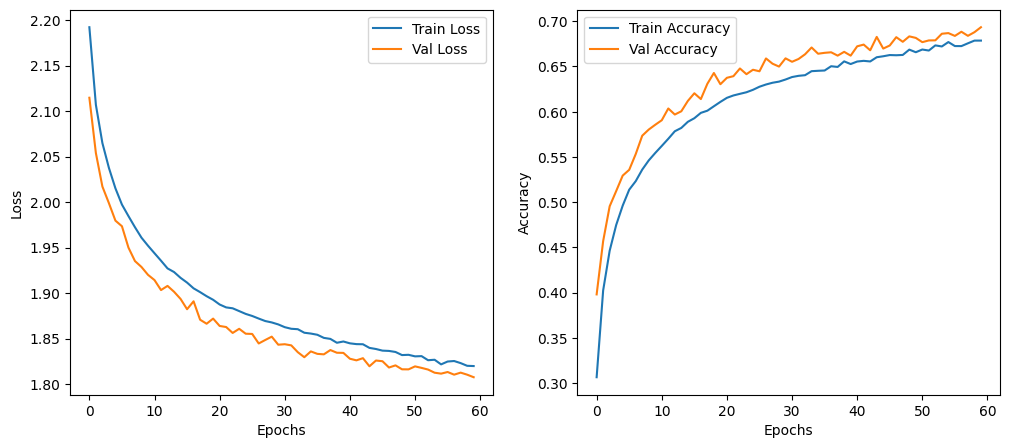

Test Accuracy: 0.6849


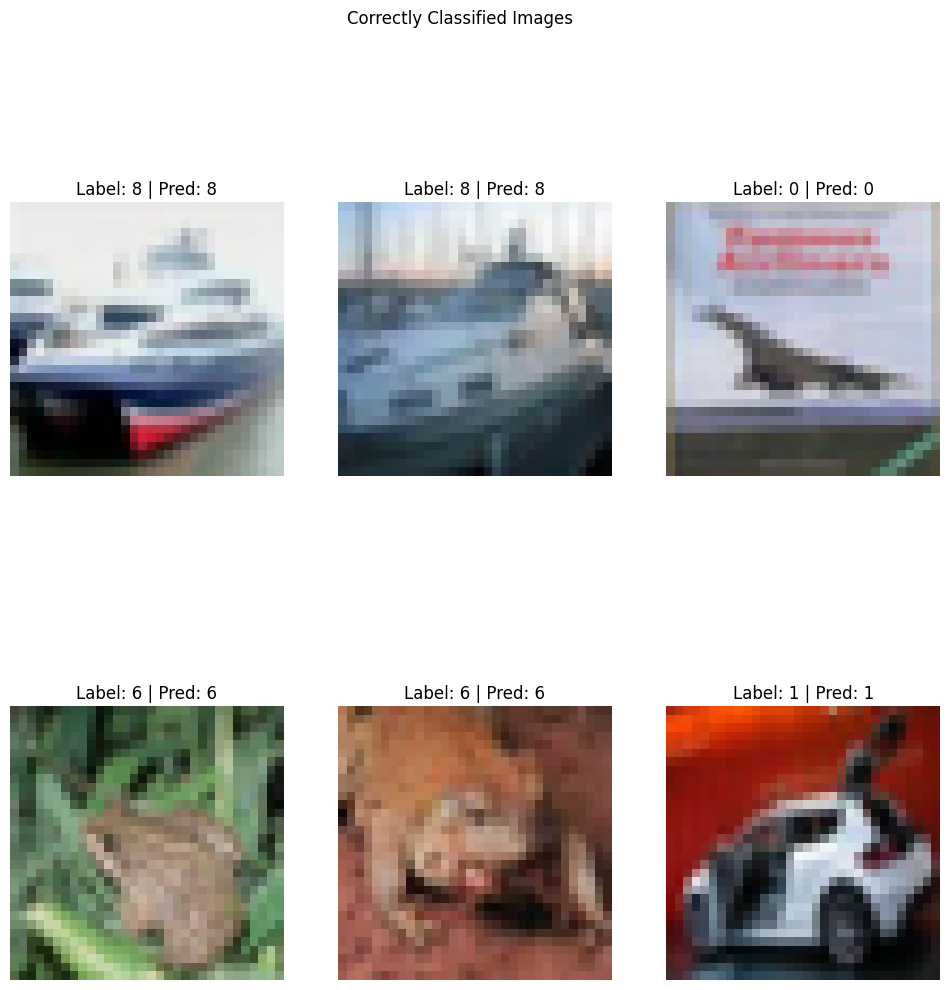

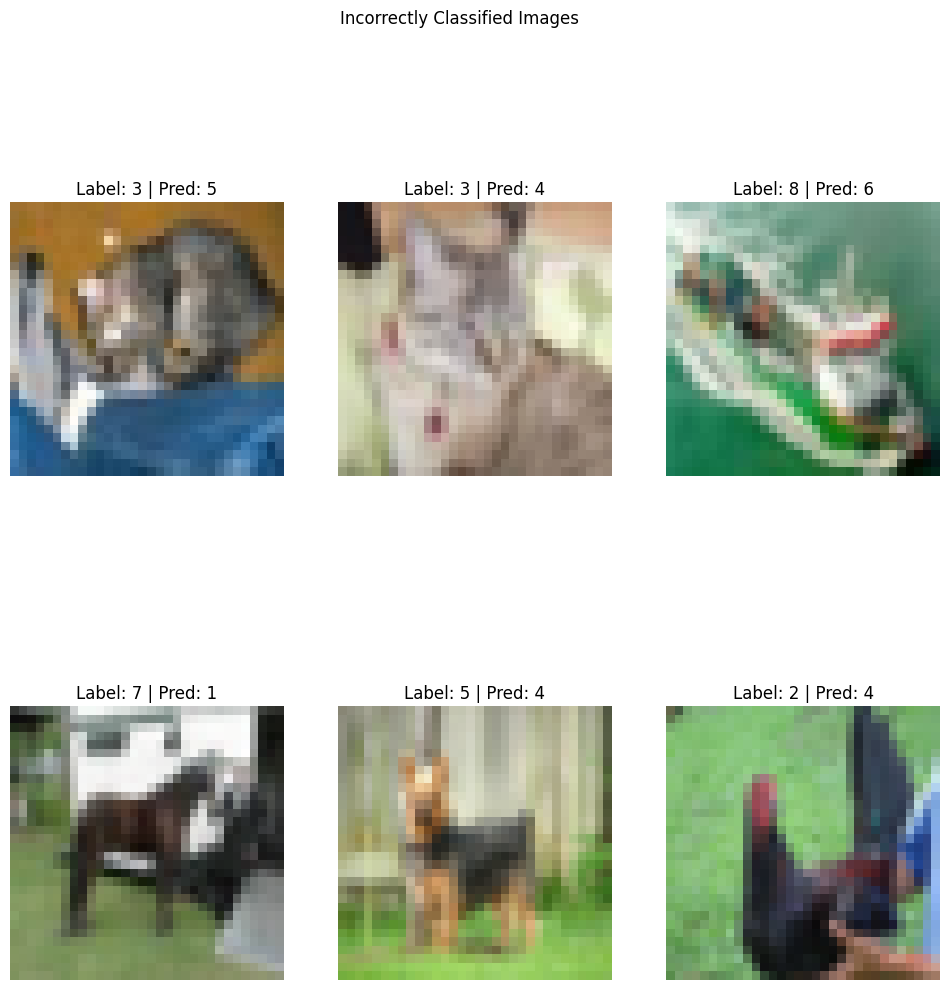

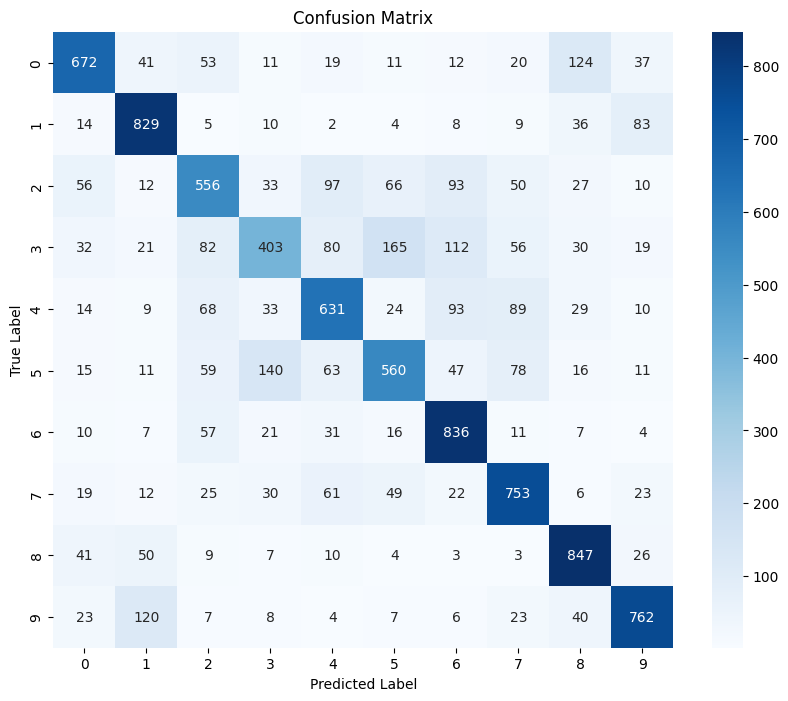

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      1000
           1       0.75      0.83      0.79      1000
           2       0.60      0.56      0.58      1000
           3       0.58      0.40      0.48      1000
           4       0.63      0.63      0.63      1000
           5       0.62      0.56      0.59      1000
           6       0.68      0.84      0.75      1000
           7       0.69      0.75      0.72      1000
           8       0.73      0.85      0.78      1000
           9       0.77      0.76      0.77      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils
from torchvision import datasets, transforms

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix random seeds for reproducibility
seed = 73
torch.manual_seed(seed)
np.random.seed(seed)

# Load CIFAR-10 dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]),
}

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=data_transforms['train'])
val_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=data_transforms['val'])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

n_classes = 10  # CIFAR-10 has 10 classes

# Define the VIB model with Conv2D layer
class VIBModel(nn.Module):
    def __init__(self):
        super(VIBModel, self).__init__()

        # Conv2D layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Flatten layer to convert 2D to 1D
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 16 * 16, 256)  # Adjusted for CIFAR-10 input size after conv layer
        self.fc2_mean = nn.Linear(256, 100)  # Z_mean
        self.fc2_var = nn.Linear(256, 100)  # Z_log_var

        # Classifier layer
        self.fc3 = nn.Linear(100, 10)  # 10 classes for CIFAR-10
        self.softmax = nn.Softmax(dim=1)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        # Passando pela camada convolucional
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten
        x = self.flatten(x)

        # Passando pelas camadas densas
        x = self.relu(self.fc1(x))

        # Mean and log variance for the latent space
        mean = self.fc2_mean(x)
        log_var = self.fc2_var(x)
        z = self.reparameterize(mean, log_var)

        # Classificação
        x = self.fc3(z)
        return self.softmax(x), mean, log_var

# Hyperparameters
beta = 1e-3
z_dim = 256
epochs = 60
learning_rate = 1e-4
decay_rate = 0.97

# Initialize the model, optimizer, and learning rate scheduler
vib = VIBModel().to(device)
optimizer = torch.optim.Adam(vib.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

# Loss function: Cross Entropy Loss (CE) + beta*KL divergence
def loss_function(y_pred, y, mu, log_var):
    CE = F.cross_entropy(y_pred, y, reduction='sum')
    KL = 0.5 * torch.sum(mu.pow(2) + torch.exp(log_var) - log_var - 1)
    return (beta * KL + CE) / y.size(0)


# Training loop
train_measures = defaultdict(list)
val_measures = defaultdict(list)
start_time = time.time()

for epoch in range(epochs):
    vib.train()
    epoch_start_time = time.time()

    train_loss = 0
    train_accuracy = 0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        vib.zero_grad()
        y_pred, mu, std = vib(X)
        loss = loss_function(y_pred, y, mu, std)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        y_pred_labels = torch.argmax(y_pred, dim=1)
        train_accuracy += (y_pred_labels == y).sum().item()

    train_measures['loss'].append(train_loss / len(train_dataloader.dataset))
    train_measures['accuracy'].append(train_accuracy / len(train_dataloader.dataset))

    # Validation loop
    vib.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)

            y_pred, mu, std = vib(X)
            loss = loss_function(y_pred, y, mu, std)
            val_loss += loss.item() * X.size(0)
            y_pred_labels = torch.argmax(y_pred, dim=1)
            val_accuracy += (y_pred_labels == y).sum().item()

    val_measures['loss'].append(val_loss / len(val_dataloader.dataset))
    val_measures['accuracy'].append(val_accuracy / len(val_dataloader.dataset))

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {train_measures['loss'][-1]:.4f}, "
          f"Train Accuracy: {train_measures['accuracy'][-1]:.4f}, "
          f"Val Loss: {val_measures['loss'][-1]:.4f}, "
          f"Val Accuracy: {val_measures['accuracy'][-1]:.4f}, "
          f"Time: {time.time() - epoch_start_time:.2f} seconds")

# Plotting the training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_measures['loss'], label='Train Loss')
plt.plot(val_measures['loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_measures['accuracy'], label='Train Accuracy')
plt.plot(val_measures['accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Testing the model
vib.eval()
test_accuracy = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)

        y_pred, mu, std = vib(X)
        y_pred_labels = torch.argmax(y_pred, dim=1)
        test_accuracy += (y_pred_labels == y).sum().item()
        all_preds.append(y_pred_labels.cpu().numpy())
        all_labels.append(y.cpu().numpy())

test_accuracy /= len(val_dataloader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Visualizing correctly classified images
correct_indices = np.where(all_preds == all_labels)[0]
incorrect_indices = np.where(all_preds != all_labels)[0]

def visualize_images(indices, title):
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(indices[:6]):
        img, label = val_dataset[idx]
        img = img.permute(1, 2, 0)  # Reshape for plotting
        img = img.numpy()
        img = img * np.array([0.247, 0.243, 0.261]) + np.array([0.4914, 0.4822, 0.4465])  # Unnormalize
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label} | Pred: {all_preds[idx]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display correct and incorrect classifications
visualize_images(correct_indices, "Correctly Classified Images")
visualize_images(incorrect_indices, "Incorrectly Classified Images")

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))